In [2]:
import pandas as pd
import seaborn as sbn
import geopandas as geo_pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import sqlite3

## Load Unit Data

In [3]:
data_dir_prefix = '../../../../data/'
database_path = data_dir_prefix + 'fire_data_v2.db'

In [4]:
# query the unit response data for 2019
with sqlite3.connect(database_path) as db_conn:
    q = """
    SELECT 
        call_number, incident_number, call_type, call_type_group, 
        unit_id, unit_type, 
        call_date, received_dttm, dispatch_dttm, on_scene_dttm,
        `neighborhooods_-_analysis_boundaries`, case_location
    FROM calls_for_service 
    WHERE cast(strftime('%Y', received_dttm) as int) = 2019 
        AND unit_sequence_in_call_dispatch <= 5"""
    unit_response_data_raw = pd.read_sql_query(q, db_conn)
    fire_station_data_raw = pd.read_sql_query("select * from fire_stations", db_conn)

print(unit_response_data_raw.dtypes)

print(fire_station_data_raw.dtypes)

call_number                              int64
incident_number                          int64
call_type                               object
call_type_group                         object
unit_id                                 object
unit_type                               object
call_date                               object
received_dttm                           object
dispatch_dttm                           object
on_scene_dttm                           object
neighborhooods_-_analysis_boundaries    object
case_location                           object
dtype: object
index                         int64
facility_id                   int64
common_name                  object
address                      object
city                         object
zip_code                      int64
block_lot                    object
owned_leased                 object
dept_id_for_jurisdiction      int64
jurisdiction                 object
gross_sq_ft                 float64
longitude                 

In [5]:
# convert dataframe to geodataframe
unit_response_data = geo_pd.GeoDataFrame(unit_response_data_raw)
unit_response_data['pt_case_location'] = geo_pd.GeoSeries.from_wkt(
    unit_response_data_raw['case_location'],
    crs='EPSG:4326')

unit_response_data = geo_pd.GeoDataFrame(unit_response_data, 
    geometry='pt_case_location')

unit_response_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 305923 entries, 0 to 305922
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   call_number                           305923 non-null  int64   
 1   incident_number                       305923 non-null  int64   
 2   call_type                             305923 non-null  object  
 3   call_type_group                       304040 non-null  object  
 4   unit_id                               305923 non-null  object  
 5   unit_type                             305923 non-null  object  
 6   call_date                             305923 non-null  object  
 7   received_dttm                         305923 non-null  object  
 8   dispatch_dttm                         305923 non-null  object  
 9   on_scene_dttm                         254063 non-null  object  
 10  neighborhooods_-_analysis_boundaries  305923 non

In [6]:
fire_stations = fire_station_data_raw.copy()
fire_stations['point'] = geo_pd.points_from_xy(fire_station_data_raw.longitude, fire_station_data_raw.latitude, crs="EPSG:4326")
fire_stations = geo_pd.GeoDataFrame(fire_stations, geometry='point')
fire_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

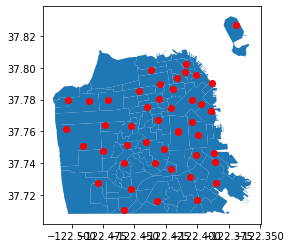

In [7]:
# grab the SF neighborhood map, plot the fire stations

sf_neighborhoods = geo_pd.read_file(data_dir_prefix+'raw/SF Find Neighborhoods.geojson')
base_map = sf_neighborhoods.geometry.plot()
fire_stations.plot(color="red", ax=base_map)

## Create Map Grid (Quadrats)

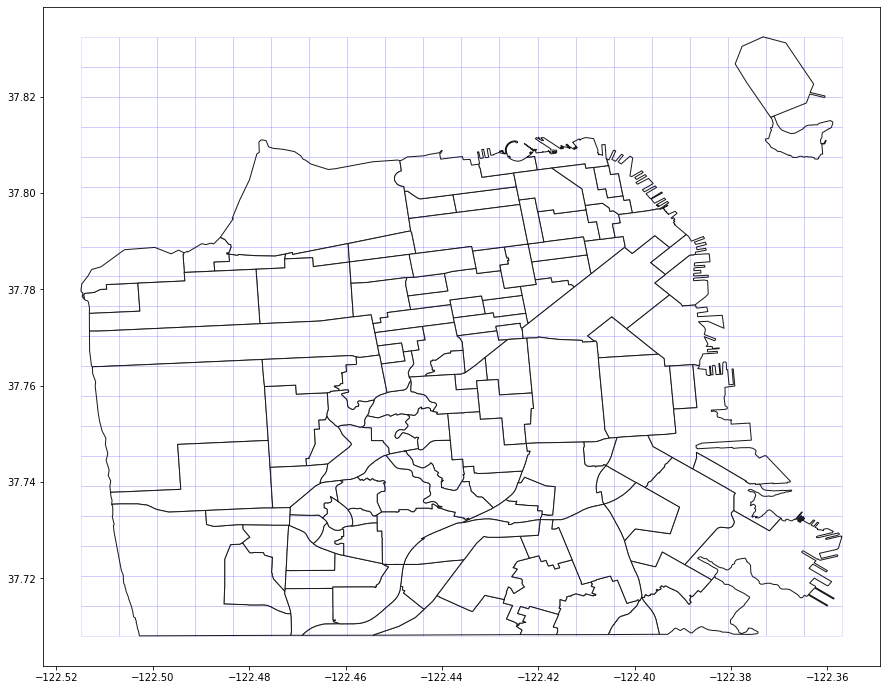

In [8]:
# create quadrat grid

from shapely.geometry import Polygon

# get dimensions of current region
xmin, ymin, xmax, ymax = sf_neighborhoods.geometry.total_bounds
step_size = 20
step_x = (xmax - xmin) / step_size
step_y = (ymax - ymin) / step_size

# create a single column of x and y, to later cross product
x_left = np.arange(xmin, xmax, step_x)
x_df = pd.DataFrame(np.column_stack((x_left,x_left + step_x)), columns=['x_left', 'x_right'])
y_top = np.arange(ymax, ymin, -step_y)
y_df = pd.DataFrame(np.column_stack((y_top, y_top - step_y)), columns=['y_top', 'y_bottom'])

# cross product dummy cols
x_df['dummy'] = 1
y_df['dummy'] = 1

# cross-product to get the grid polygons
grid_polygons = x_df.merge(y_df, on='dummy', how='inner').drop("dummy", axis=1)
grid_polygons

# plot the quadrats
plt.rcParams["figure.figsize"]=15,15
grid_poly = geo_pd.GeoSeries(grid_polygons.apply(lambda d: Polygon([    
    (d.x_left, d.y_top),    
    (d.x_left, d.y_bottom),
    (d.x_right, d.y_bottom),
    (d.x_right, d.y_top)]), axis = 1))

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_poly.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.1)

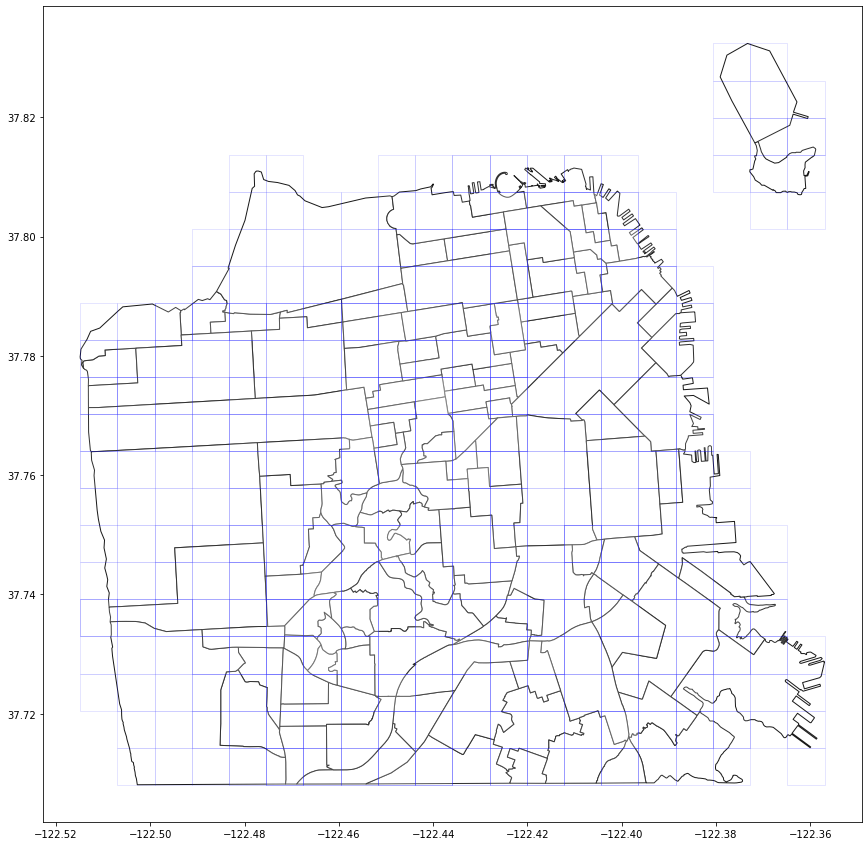

In [9]:

grid_zones = grid_poly.to_frame("zone").reset_index().rename({"index": "zone_idx"}, axis=1)
grid_zones = geo_pd.GeoDataFrame(grid_zones, crs="EPSG:4326", geometry='zone')
grid_zones = geo_pd.sjoin(grid_zones, sf_neighborhoods, how='inner', op='intersects')[['zone_idx', 'zone']]

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_zones.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.1)

In [10]:
grid_zones['centroid'] = grid_zones.geometry.centroid
grid_zones.to_csv(data_dir_prefix + "/raw/zone_grid.csv")

/tmp/ipykernel_7547/4250326246.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_zones['centroid'] = grid_zones.geometry.centroid


## Assign firestations to quadrats


In [24]:
facility_zones.columns

Index(['index', 'facility_id', 'common_name', 'address', 'city', 'zip_code',
       'block_lot', 'owned_leased', 'dept_id_for_jurisdiction', 'jurisdiction',
       'gross_sq_ft', 'longitude', 'latitude', 'supervisor_district',
       'city_tenants', 'land_id', 'point', 'index_right', 'zone_idx',
       'centroid'],
      dtype='object')

## Calculate Catchments for each Unit

In [13]:
# see if unit responses typically fit into a handful of neighborhoods
pd.set_option('display.max_rows', 30)

unit_response_data['unit_desc'] = unit_response_data.unit_type + ' - ' + unit_response_data.unit_id
unit_response_summary = unit_response_data.groupby(['unit_desc', 'neighborhooods_-_analysis_boundaries'])\
    .agg({'incident_number':'count'}).unstack(fill_value=0.0)

unit_response_summary.to_csv(data_dir_prefix+'raw/unit_response_summary.csv')

unit_response_summary

incident_number                 \
neighborhooods_-_analysis_boundaries Bayview Hunters Point Bernal Heights   
unit_desc                                                                   
AIRPORT - AP                                           0.0            0.0   
CHIEF - B01                                            3.0            0.0   
CHIEF - B02                                            4.0            3.0   
CHIEF - B03                                           22.0           11.0   
CHIEF - B04                                            0.0            0.0   
...                                                    ...            ...   
TRUCK - T16                                            0.0            0.0   
TRUCK - T17                                          961.0            6.0   
TRUCK - T18                                            1.0            0.0   
TRUCK - T19                                            0.0            0.0   
TRUCK - T48                                            1.0            0.0   

                                                                              \
neighborhooods_-_analysis_boundaries Castro/Upper Market Chinatown Excelsior   
unit_desc                                                                      
AIRPORT - AP                                         0.0       0.0       0.0   
CHIEF - B01                                          0.0     370.0       0.0   
CHIEF - B02                                        151.0       1.0       0.0   
CHIEF - B03                                          0.0      23.0       0.0   
CHIEF - B04                                          1.0      22.0       0.0   
...                                                  ...       ...       ...   
TRUCK - T16                                          0.0       0.0       0.0   
TRUCK - T17                                          0.0       0.0       0.0   
TRUCK - T18                                          0.0       0.0       0.0   
TRUCK - T19                                          0.0       0.0       7.0   
TRUCK - T48                                          0.0       0.0       0.0   

                                                                               \
neighborhooods_-_analysis_boundaries Financial District/South Beach Glen Park   
unit_desc                                                                       
AIRPORT - AP                                                    0.0       0.0   
CHIEF - B01                                                   742.0       0.0   
CHIEF - B02                                                    43.0       1.0   
CHIEF - B03                                                   894.0       0.0   
CHIEF - B04                                                    13.0       0.0   
...                                                             ...       ...   
TRUCK - T16                                                    22.0       0.0   
TRUCK - T17                                                     3.0       0.0   
TRUCK - T18                                                     0.0       0.0   
TRUCK - T19                                                     0.0       0.0   
TRUCK - T48                                                     4.0       0.0   

                                                                      \
neighborhooods_-_analysis_boundaries Golden Gate Park Haight Ashbury   
unit_desc                                                              
AIRPORT - AP                                      0.0            0.0   
CHIEF - B01                                       0.0            0.0   
CHIEF - B02                                       1.0           27.0   
CHIEF - B03                                       0.0            0.0   
CHIEF - B04                                       0.0            1.0   
...                                               ...            ...   
TRUCK - T16                                       1.0       

In [52]:
%matplotlib agg
%matplotlib agg

plt.rcParams["figure.figsize"]=20,20

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import shapely.wkt

unit_ids = []
bounding_boxes = []

for selected_unit in unit_response_summary.index.to_list():

    if not(selected_unit.startswith("TRUCK") or selected_unit.startswith("ENGINE")):
        continue

    selected_unit_data = unit_response_data.loc[unit_response_data['unit_desc'] == selected_unit]
    selected_unit_response_time = (
        pd.to_datetime(selected_unit_data.on_scene_dttm) - pd.to_datetime(selected_unit_data.dispatch_dttm)
    ) / np.timedelta64(1, 'm')

    selected_unit_data = selected_unit_data.loc[selected_unit_response_time < 6]

    if selected_unit_data.shape[0] < 100:
        continue
 
    unit_X = np.concatenate([
        selected_unit_data.geometry.x.to_numpy().reshape(-1, 1),
        selected_unit_data.geometry.y.to_numpy().reshape(-1, 1)], axis=1)

    col_x = unit_X[:,0]
    col_y = unit_X[:,1]

    def kde2D(x, y, xbins=100j, ybins=100j, **kwargs): 
        """Build 2D kernel density estimate (KDE)."""

        # create grid of sample locations (default: 100x100)
        xx, yy = np.mgrid[x.min():x.max():xbins, 
                        y.min():y.max():ybins]

        xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
        xy_train  = np.vstack([y, x]).T

        bandwidths = np.logspace(-4, -1, 8)
        kde_skl = KernelDensity(metric='haversine')
        grid = GridSearchCV(kde_skl, 
                        {'bandwidth': bandwidths,
                        'kernel' : ["gaussian", "exponential", "linear",]}, n_jobs=6)
        grid.fit(xy_train)

        kde_skl = KernelDensity(
            bandwidth=grid.best_params_["bandwidth"],
            kernel=grid.best_params_["kernel"],
            metric='haversine')
        
        kde_skl.fit(xy_train)

        # score_samples() returns the log-likelihood of the samples
        z = np.exp(kde_skl.score_samples(xy_sample))
        
        return kde_skl, xx, yy, np.reshape(z, xx.shape)

    kde_est, xx, yy, zz = kde2D(col_x, col_y)

    # create plot grid
    fig, axs = plt.subplots(2, 2)

    # plot countours
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 0])
    _ = selected_unit_data.plot(ax=base_plot)
    _ = axs[0, 0].contour(xx, yy, zz)

    # plot all points w/ heatmap
    unit_scores = kde_est.score_samples(np.vstack([col_y, col_x]).T)
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 1])
    _ = selected_unit_data.plot(ax=base_plot, c=unit_scores)

    # plot filtered points w/ heatmap
    unit_scores_df = pd.DataFrame({"unit_score":pd.Series(unit_scores)})
    output = pd.concat([selected_unit_data.reset_index(drop=True), unit_scores_df.reset_index(drop=True)], axis=1)
    output = output.loc[output.unit_score.quantile(0.1) < output.unit_score]
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 0])
    _ = output.plot(ax=base_plot, c=output.unit_score)

    # bounding box
    bounding_box = MultiPoint([shapely.wkt.loads(p) for p in list(output.geometry.to_wkt())]).convex_hull
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 1])
    _ = output.plot(ax=base_plot, c=output.unit_score)
    _ = geo_pd.GeoSeries(bounding_box).plot(ax=base_plot, alpha=0.5, color='purple')

    plt.savefig('kde_imgs/filter-' + selected_unit + '.png', transparent=False)

    # store bounding box and unit
    unit_ids.append(selected_unit)
    bounding_boxes.append(bounding_box)


%matplotlib inline

In [55]:
catchment_areas = geo_pd.GeoDataFrame({
    "unit_desc": pd.Series(unit_ids),
    "bounding_box" : geo_pd.GeoSeries(bounding_boxes)}, geometry="bounding_box")
    
catchment_areas.to_csv(data_dir_prefix+'raw/catchments.csv')


In [40]:
(pd.to_datetime(selected_unit_data.on_scene_dttm) - pd.to_datetime(selected_unit_data.dispatch_dttm)) / np.timedelta64(1, 'm')

25              NaN
30         5.633333
79         2.833333
153        1.333333
186        1.633333
            ...    
305819     4.466667
305827    13.450000
305829     3.750000
305856     1.183333
305896     6.183333
Length: 7466, dtype: float64

## Calculate Demand Grid